In [2]:
from sklearn.datasets import fetch_openml
import numpy as np


def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
print("======")
print(mnist)

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'target': array([0, 0, 0, ..., 9, 9, 9], dtype=int8), 'feature_names': ['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8', 'pixel9', 'pixel10', 'pixel11', 'pixel12', 'pixel13', 'pixel14', 'pixel15', 'pixel16', 'pixel17', 'pixel18', 'pixel19', 'pixel20', 'pixel21', 'pixel22', 'pixel23', 'pixel24', 'pixel25', 'pixel26', 'pixel27', 'pixel28', 'pixel29', 'pixel30', 'pixel31', 'pixel32', 'pixel33', 'pixel34', 'pixel35', 'pixel36', 'pixel37', 'pixel38', 'pixel39', 'pixel40', 'pixel41', 'pixel42', 'pixel43', 'pixel44', 'pixel45', 'pixel46', 'pixel47', 'pixel48', 'pixel49', 'pixel50', 'pixel51', 'pixel52', 'pixel53', 'pixel54', 'pixel55', 'pixel56', 'pixel57', 'pixel58', 'pixel59', 'pixel60', 'pixel61', 'pixel62', 'pix

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


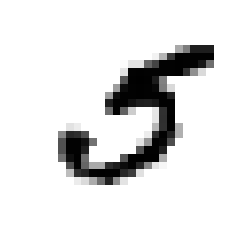

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
print(y[36000])

5


In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
# 有些算法对排好序的数据更加敏感，排好序说明两个行很相似
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index],y_train[shuffle_index] 

In [7]:
# 使用随机梯度下降算法
from sklearn.linear_model import SGDClassifier


y_train_5 = (y_train == 5)
y_test_t = (y_test == 5)

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=0.1)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([ True])

In [8]:
# 自定义交叉验证
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.96395


0.96945


0.95135


In [9]:
from sklearn.model_selection import cross_val_score


cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96395, 0.96945, 0.95135])

In [10]:
# 下边演示一个对于分类器存在的问题，如果数据集是偏斜的，指包含某一类远远大于另一类，如果仅仅预测那个大的，
# 得到的精度也很高
# 下边的例子中有90%的结果都不是5，所以产生了很高的精度
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9087 , 0.909  , 0.91125])

In [11]:
from sklearn.model_selection import cross_val_predict


y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)

[False False False ... False False False]


In [12]:
# 混淆矩阵
from sklearn.metrics import confusion_matrix


confusion_matrix(y_train_5, y_train_pred)

array([[53399,  1180],
       [ 1125,  4296]])

In [13]:
from sklearn.metrics import precision_score, recall_score


precision_score(y_train_5, y_train_pred)


0.7845142439737034

In [14]:
recall_score(y_train_5, y_train_pred)

0.7924737133370227

In [15]:
from sklearn.metrics import f1_score


f1_score(y_train_5, y_train_pred)

0.7884738918968522

In [16]:
# 通过决策函数可以返回决策分数，通过控制这个分数的下限，就可以实现精度和召回的控制
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

threshold = 3000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[108.23734896]
[ True]
[False]


In [17]:
# 获取scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)
print(len(y_scores))

[-17186.54201291 -13902.72590167 -15972.40879221 ... -16147.74895772
 -15201.1831391  -12556.41466713]
60000


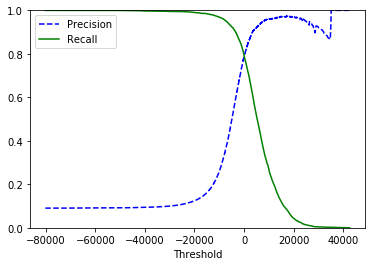

In [18]:
from sklearn.metrics import precision_recall_curve


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [19]:
# 如果确实想控制precision或者recall的话，可以这样实现
y_train_pred_90 = (y_scores > 5000)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.5159564655967533

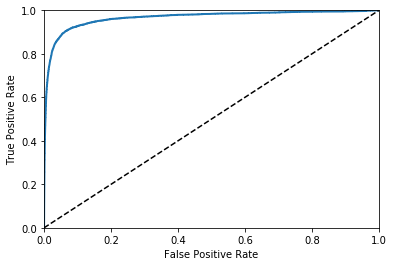

In [20]:
# 接收者操作特征曲线
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    

plot_roc_curve(fpr, tpr)
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_train_5, y_scores)

0.9660644932844258

In [22]:
from sklearn.ensemble import RandomForestClassifier


forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method="predict_proba")
# y_probas_forest并不包含scores，因此我们用概率代替
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


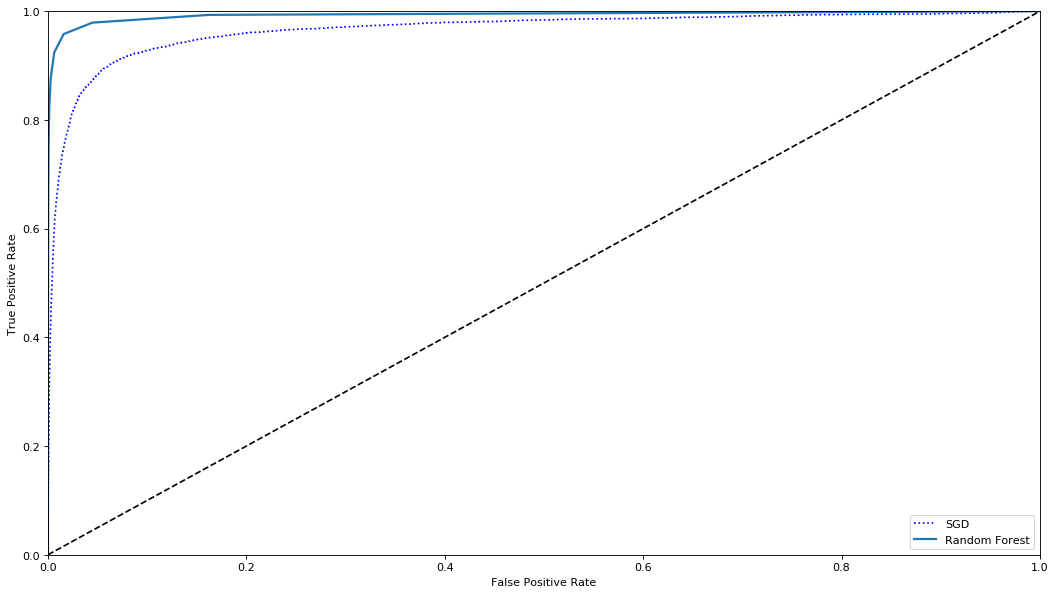

In [23]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 9), dpi=80, facecolor='w', edgecolor='k')


plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [24]:
# 求曲线下的面积
roc_auc_score(y_train_5, y_scores_forest)

0.9930611591045461

In [25]:
# sklean中，如果对于多类问题，使用了二进制分类算法，则默认使用OvA，除非是svm
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [26]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-16435.99360932, -22020.2078959 , -16180.43731135,
         -2651.19394153, -11162.51700477,    108.23734896,
        -15435.22973158, -17660.76704045, -13998.69313799,
        -14196.54087665]])

In [27]:
np.argmax(some_digit_scores)
print(sgd_clf.classes_)

[0 1 2 3 4 5 6 7 8 9]


In [28]:
from sklearn.multiclass import OneVsOneClassifier


ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, tol=0.1))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
print(len(ovo_clf.estimators_))

45


In [29]:
# 随机森林有点不一样，它本身就预测了各个值的概率
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[5]


In [30]:
print(forest_clf.predict_proba([some_digit]))

[[0.  0.  0.  0.2 0.  0.8 0.  0.  0.  0. ]]


In [31]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8815237 , 0.87829391, 0.87248087])

In [32]:
# 通过scaling参数，获取更好的结果
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91276745, 0.90974549, 0.91218683])

In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5718,    2,   22,   10,   11,   51,   44,    8,   53,    4],
       [   1, 6477,   46,   27,    6,   42,    5,   11,  116,   11],
       [  47,   34, 5329,  104,   80,   32,   79,   57,  185,   11],
       [  40,   37,  131, 5359,    1,  231,   32,   48,  157,   95],
       [  21,   24,   44,   11, 5355,    9,   53,   32,  100,  193],
       [  60,   32,   33,  183,   64, 4633,   91,   31,  208,   86],
       [  29,   25,   50,    2,   38,   96, 5607,    8,   62,    1],
       [  19,   23,   69,   31,   52,   11,    5, 5783,   21,  251],
       [  44,  127,   61,  146,    9,  142,   48,   17, 5137,  120],
       [  39,   31,   29,   91,  150,   38,    2,  180,   93, 5296]])

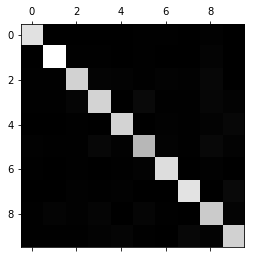

In [34]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

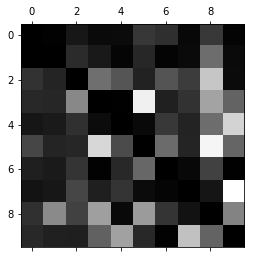

In [35]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

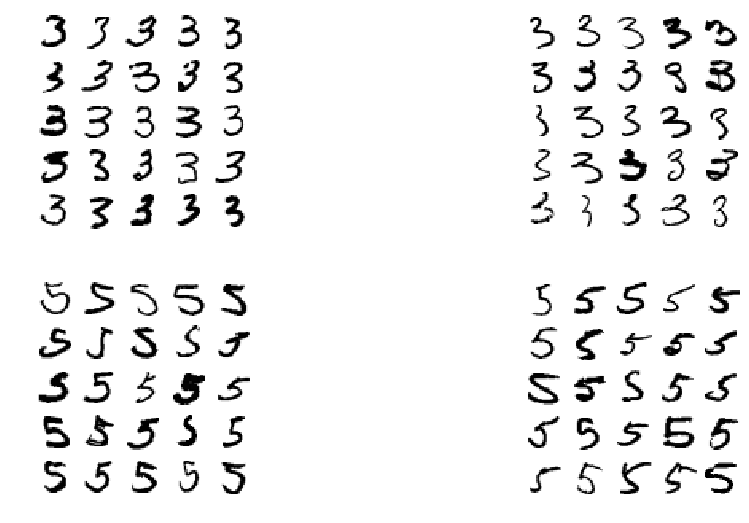

In [36]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(16, 9))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [37]:
from sklearn.neighbors import KNeighborsClassifier


y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

[[24. 91. 14. ... 34. 44.  8.]
 [29. 66. 50. ... 47. 48. 59.]
 [ 2. 15. 54. ... 50. 75. 31.]
 ...
 [40. 72. 82. ... 87. 87. 21.]
 [89. 56. 89. ... 90. 44. 32.]
 [ 5. 95. 67. ... 55. 83. 90.]]


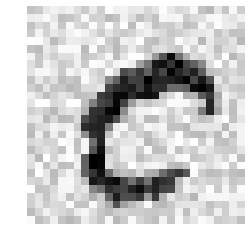

In [42]:
import numpy.random as rnd


train_noise = rnd.randint(0, 100, (len(X_train), 784))
test_noise = rnd.randint(0, 100, (len(X_test), 784))

X_train_mod = X_train + train_noise
X_test_mod = X_test + test_noise

y_train_mod = X_train
y_test_mod = X_test

print(X_test_mod)
some_index = 200
some_digit_image = X_test_mod[some_index].reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

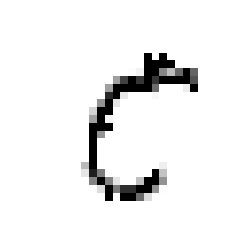

In [46]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
some_digit_image = clean_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [47]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")


0.9768114127437344